## match

In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import sys
import time

class matchers:
	def __init__(self):
		self.surf = cv2.xfeatures2d.SURF_create()
		FLANN_INDEX_KDTREE = 0
		index_params = dict(algorithm=0, trees=5)
		search_params = dict(checks=50)
		self.flann = cv2.FlannBasedMatcher(index_params, search_params)

	def match(self, i1, i2, direction=None):
		imageSet1 = self.getSURFFeatures(i1)
		imageSet2 = self.getSURFFeatures(i2)
		print("Direction : ", direction)
		matches = self.flann.knnMatch(
			imageSet2['des'],
			imageSet1['des'],
			k=2
			)
		good = []
		for i , (m, n) in enumerate(matches):
			if m.distance < 0.7*n.distance:
				good.append((m.trainIdx, m.queryIdx))

		if len(good) > 4:
			pointsCurrent = imageSet2['kp']
			pointsPrevious = imageSet1['kp']

			matchedPointsCurrent = np.float32(
				[pointsCurrent[i].pt for (__, i) in good]
			)
			matchedPointsPrev = np.float32(
				[pointsPrevious[i].pt for (i, __) in good]
				)

			H, s = cv2.findHomography(matchedPointsCurrent, matchedPointsPrev, cv2.RANSAC, 4)
			return H
		return None

	def getSURFFeatures(self, im):
		gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
		kp, des = self.surf.detectAndCompute(gray, None)
		return {'kp':kp, 'des':des}

### 拼接

#### 读取文件目录

In [2]:
args = "txtlists/files4.txt"
path = args
fp = open(path, 'r')
filenames = [each.rstrip('\r\n') for each in  fp.readlines()]
print(filenames)

['../images/xie1.jpg', '../images/xie2.jpg', '../images/xie3.jpg']


In [3]:
images = [cv2.resize(cv2.imread(each),(480, 320)) for each in filenames]
count = len(images)
left_list, right_list, center_im = [], [],None
matcher_obj = matchers()

#### 分出左边的图与右边的图

In [4]:
def prepare_lists():
    print("Number of images : %d"%count)
    centerIdx = count/2
    print("Center index image : %d"%centerIdx)
    center_im = images[int(centerIdx)]
    for i in range(count):
        if(i<=centerIdx):
            left_list.append(images[i])
        else:
            right_list.append(images[i])
    print("Image lists prepared")

In [5]:
prepare_lists()

Number of images : 3
Center index image : 1
Image lists prepared


### 左图移动

In [6]:
def leftshift():
    a = left_list[0]
    print(a.shape)
    for b in left_list[1:]:
        print(b.shape)
        H = matcher_obj.match(a, b, 'left')
        print("Homography is : ", H)
        xh = np.linalg.inv(H)
        print("Inverse Homography :", xh)
        ds = np.dot(xh, np.array([a.shape[1], a.shape[0], 1]));
        ds = ds/ds[-1]
        print("final ds=>", ds)
        f1 = np.dot(xh, np.array([0,0,1]))
        f1 = f1/f1[-1]
        xh[0][-1] += abs(f1[0])
        xh[1][-1] += abs(f1[1])
        ds = np.dot(xh, np.array([a.shape[1], a.shape[0], 1]))
        offsety = abs(int(f1[1]))
        offsetx = abs(int(f1[0]))
        print(offsety)
        print(offsetx)
        dsize = (int(ds[0])+offsetx, int(ds[1]) + offsety)
        print("image dsize =>", dsize)
        tmp = cv2.warpPerspective(a, xh, dsize)
        
        plt.figure("Left") # 图像窗口名称
        plt.imshow(tmp)
        plt.axis('on') # 关掉坐标轴为 off
        plt.title('left') # 图像题目
        plt.show()
        # cv2.imshow("warped", tmp)
        # cv2.waitKey()
        # ------>将右边的图拼到左边
        tmp[offsety:b.shape[0]+offsety, offsetx:b.shape[1]+offsetx] = b
        a = tmp
        print(a.shape)
        
        plt.figure("Left") # 图像窗口名称
        plt.imshow(a)
        plt.axis('on') # 关掉坐标轴为 off
        plt.title('left') # 图像题目
        plt.show()

        leftImage = tmp
        return leftImage

(320, 480, 3)
(320, 480, 3)
Direction :  left
Homography is :  [[ 5.15753177e-01 -7.27063193e-02  2.31281069e+02]
 [-1.03147320e-01  8.32353256e-01  2.10970900e+01]
 [-9.29009602e-04  2.36661181e-05  1.00000000e+00]]
Inverse Homography : [[ 1.38357853e+00  1.30032383e-01 -3.22738827e+02]
 [ 1.38960820e-01  1.21519398e+00 -5.77760638e+01]
 [ 1.28206908e-03  9.20424085e-05  7.01539866e-01]]
final ds=> [284.45710341 295.44798265   1.        ]
82
460
image dsize => (1303, 562)


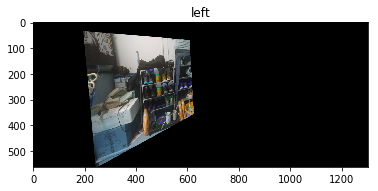

(562, 1303, 3)


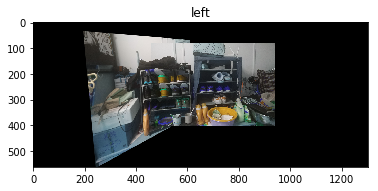

In [7]:
leftImage = leftshift()

In [8]:
def trim_left():
    pass

### 移动右图

In [9]:
def rightshift():
    for each in right_list:
        H = matcher_obj.match(leftImage, each, 'right')
        print("Homography :", H)
        txyz = np.dot(H, np.array([each.shape[1], each.shape[0], 1]))
        txyz = txyz/txyz[-1]
        dsize = (int(txyz[0])+leftImage.shape[1], int(txyz[1])+leftImage.shape[0])
        tmp = cv2.warpPerspective(each, H, dsize)
        
        plt.figure("Right") # 图像窗口名称
        plt.imshow(tmp)
        plt.axis('on') # 关掉坐标轴为 off
        plt.title('Right') # 图像题目
        plt.show()
        
        return tmp

Direction :  right
Homography : [[ 1.35835637e-01 -9.66816043e-02  6.52746121e+02]
 [-1.78342253e-01  7.99023472e-01  1.09107713e+02]
 [-8.88198341e-04 -4.50443807e-05  1.00000000e+00]]


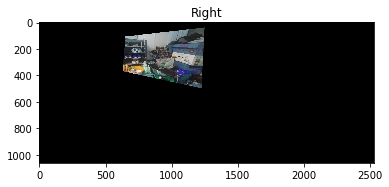

In [10]:
Right_image = rightshift()

### 中间合并

In [11]:
def mix_and_match(leftImage, warpedImage):
    i1y, i1x = leftImage.shape[:2]
    i2y, i2x = warpedImage.shape[:2]
    print(leftImage[-1,-1])
    
    t = time.time()
    black_l = np.where(leftImage == np.array([0,0,0]))
    black_wi = np.where(warpedImage == np.array([0,0,0]))
    print(time.time() - t)
    print(black_l[-1])

    for i in range(0, i1x):
        for j in range(0, i1y):
            try:
                if(np.array_equal(leftImage[j,i],np.array([0,0,0])) and  np.array_equal(warpedImage[j,i],np.array([0,0,0]))):
                    # print "BLACK"
                    # instead of just putting it with black, 
                    # take average of all nearby values and avg it.
                    warpedImage[j,i] = [0, 0, 0]
                else:
                    if(np.array_equal(warpedImage[j,i],[0,0,0])):
                        # print "PIXEL"
                        warpedImage[j,i] = leftImage[j,i]
                    else:
                        if not np.array_equal(leftImage[j,i], [0,0,0]):
                            bw, gw, rw = warpedImage[j,i]
                            bl,gl,rl = leftImage[j,i]
                            # b = (bl+bw)/2
                            # g = (gl+gw)/2
                            # r = (rl+rw)/2
                            warpedImage[j, i] = [bl,gl,rl]
            except:
                pass
    plt.figure("waRPED mix") # 图像窗口名称
    plt.imshow(warpedImage)
    plt.axis('on') # 关掉坐标轴为 off
    plt.title('waRPED mix') # 图像题目
    plt.show()
    # cv2.imshow("waRPED mix", warpedImage)
    # cv2.waitKey()
    return warpedImage

(562, 1303, 3)
[0 0 0]
0.23636865615844727
[0 1 2 ... 0 1 2]


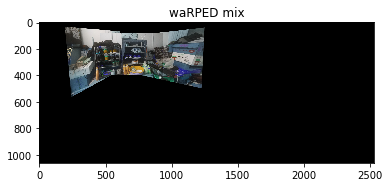

(1061, 2531, 3)


In [12]:
print(leftImage.shape)
leftImage = mix_and_match(leftImage, Right_image)
print(leftImage.shape)

### 保存结果

In [13]:
print("done")
cv2.imwrite("test12.jpg", leftImage)
print("image written")

done
image written
